In [3]:
library(zellkonverter)
library(SingleCellExperiment)
library(dreamlet)

options(repr.plot.width = 20, repr.plot.height = 16, repr.plot.res = 100)

In [4]:
library(BiocParallel)
multicoreParam <- MulticoreParam(workers = 8)
multicoreParam

class: MulticoreParam
  bpisup: FALSE; bpnworkers: 8; bptasks: 0; bpjobname: BPJOB
  bplog: FALSE; bpthreshold: INFO; bpstopOnError: TRUE
  bpRNGseed: ; bptimeout: NA; bpprogressbar: FALSE
  bpexportglobals: TRUE; bpexportvariables: FALSE; bpforceGC: FALSE
  bpfallback: TRUE
  bplogdir: NA
  bpresultdir: NA
  cluster type: FORK

In [2]:
# Create SingleCellExperiment object that points to on-disk H5AD file, R reader as more than 2**31 elements.
sce <- readH5AD('/data/yosef3/users/can/immune_aging/mrvi_analysis/cd4_mrvi_processed.h5ad', use_hdf5=TRUE, verbose = TRUE)
sce

ℹ Using the Python reader

ℹ Using anndata version 0.8.0

⠙ Reading '/.../.../.../.../.../.../cd4_mrvi_processed.h5ad '
✔ Read /.../.../.../.../.../.../cd4_mrvi_processed.h5ad  48.3s]


ℹ Converting AnnData to SingleCellExperiment
ℹ Converting uns to metadata
ℹ Converting uns
ℹ Converting uns$DE_IL17A_colors
✔ uns$DE_IL17A_colors converted s]


ℹ Converting uns
ℹ Converting uns$Gut Module 0_colors
✔ uns$Gut Module 0_colors converted s]


ℹ Converting uns
ℹ Converting uns$Gut Module 1_colors
✔ uns$Gut Module 1_colors converted s]


ℹ Converting uns
ℹ Converting uns$Gut Module 2_colors
✔ uns$Gut Module 2_colors converted s]


ℹ Converting uns
ℹ Converting uns$Gut Module 3_colors
✔ uns$Gut Module 3_colors converted s]


ℹ Converting uns
ℹ Converting uns$Gut Module Consensus Redo_colors
✔ uns$Gut Module Consensus Redo_colors converted s]


ℹ Converting uns
ℹ Converting uns$Gut Module Consensus_colors
✔ uns$Gut Module Consensus_colors converted s]


ℹ Converting uns
ℹ Converting uns$LN Modu

class: SingleCellExperiment 
dim: 10000 361629 
metadata(29): DE_IL17A_colors Gut.Module.0_colors ...
  tissue_groups_colors umap
assays(5): X counts lfc_model_all log_norm_counts scaled_norm_counts
rownames(10000): AP006222.2 AL645608.6 ... AC136616.2 AC141272.1
rowData names(16): gene_ids feature_types ... mean std
colnames(361629): AAACCCAAGAGAGCGG-1_CZINY-0064-14
  AAACCCAAGAGGGTCT-1_CZINY-0054-5 ... TTTGTTGTCTCTGACC-1_CZINY-0104-7
  TTTGTTGTCTGATTCT-1_CZINY-0056-7
colData names(95): n_genes n_genes_by_counts ... LN.mrVI.LFC.3.filtered
  LN.Module.Consensus
reducedDimNames(25): BCR_IR TCR_IR ... removed_proteins versions
mainExpName: NULL
altExpNames(0):

In [3]:
rowData(sce)$gene_names <- rownames(sce)

In [10]:
colData(sce)$age_group <- gsub(">", "over", colData(sce)$age_group)
colData(sce)$age_group <- gsub("<", "under", colData(sce)$age_group)
colData(sce)$age_group <- as.factor(colData(sce)$age_group)
colData(sce)$age_group <- relevel(colData(sce)$age_group, ref = "under40")

In [22]:
colData(sce)$tissue_age <- as.factor(paste(colData(sce)$tissue_groups, colData(sce)$age_group, sep = "_"))
colData(sce)$tissue_age <- relevel(colData(sce)$tissue_age, ref = "BLO_under40")

# Lung

## Preprocess

In [23]:
pb <- aggregateToPseudoBulk(
    sce,
    assay = "counts",
    cluster_id = "Lung.Module.Consensus",
    sample_id = "donor_tissue",
    verbose = TRUE)
# one 'assay' per cell type
assayNames(pb)
rownames(pb) <- rowData(sce)$genes
saveRDS(pb, file='pseudobulk_mrvi_lung.rds')

[1] "Lung mrVI LFC 0 normalized" "Lung mrVI LFC 1 normalized"
[3] "Lung mrVI LFC 2 normalized" "Lung mrVI LFC 3 normalized"

class: MulticoreParam
  bpisup: FALSE; bpnworkers: 8; bptasks: 0; bpjobname: BPJOB
  bplog: FALSE; bpthreshold: INFO; bpstopOnError: TRUE
  bpRNGseed: ; bptimeout: NA; bpprogressbar: FALSE
  bpexportglobals: TRUE; bpexportvariables: FALSE; bpforceGC: FALSE
  bpfallback: TRUE
  bplogdir: NA
  bpresultdir: NA
  cluster type: FORK

In [25]:
rownames(pb) <- rowData(pb)$gene_names

In [26]:
# Normalize and apply voom/voomWithDreamWeights
res.proc = processAssays( pb, ~ tissue + cmv + age_group + sex + chemistry + site + 0, min.cells=10, min.count=5, min.prop=0.1, BPPARAM=multicoreParam)

# the resulting object of class dreamletProcessedData stores
# normalized data and other information
res.proc

  Lung mrVI LFC 0 normalized...
1.7 secs

  Lung mrVI LFC 1 normalized...
1.7 secs

  Lung mrVI LFC 2 normalized...
1 secs

  Lung mrVI LFC 3 normalized...
1.6 secs



class: dreamletProcessedData 
assays(4): Lung mrVI LFC 0 normalized Lung mrVI LFC 1 normalized Lung
  mrVI LFC 2 normalized Lung mrVI LFC 3 normalized
colData(23): donor site ... tissue_groups tissue_age
metadata(45): Lung.Module.Consensus donor_tissue ...
  LN.mrVI.LFC.2.filtered LN.mrVI.LFC.3.filtered
Samples:
 min: 112 
 max: 176
Genes:
 min: 1803 
 max: 3218 
details(7): assay n_retain ... n_errors error_initial

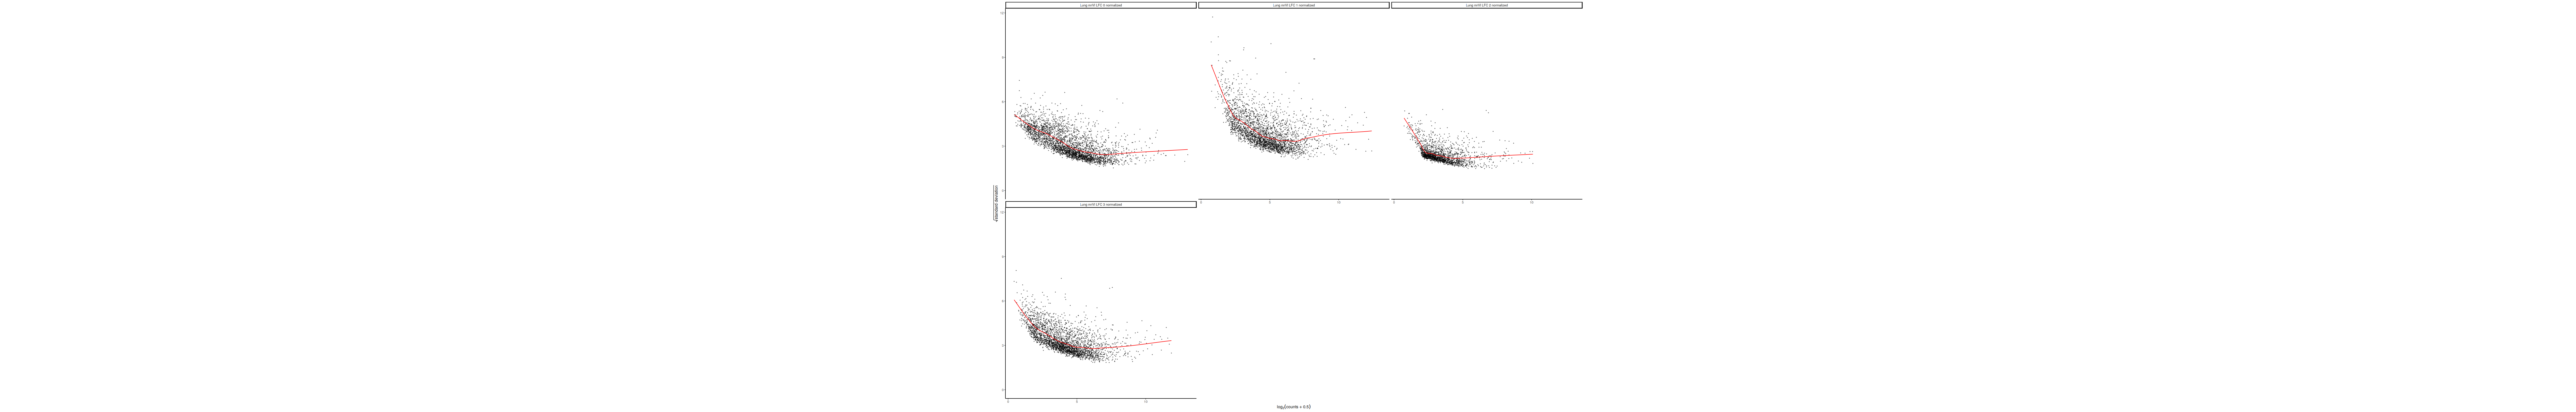

In [27]:
# show voom plot for each cell clusters 
options(repr.plot.width = 100, repr.plot.height = 16, repr.plot.res = 100)
plotVoom(res.proc)

In [28]:
saveRDS(res.proc, file='pseudobulk_mrvi_lung_preprocessed.rds')

## DE test aging

In [5]:
res.proc <- readRDS(file='pseudobulk_mrvi_lung_preprocessed.rds')

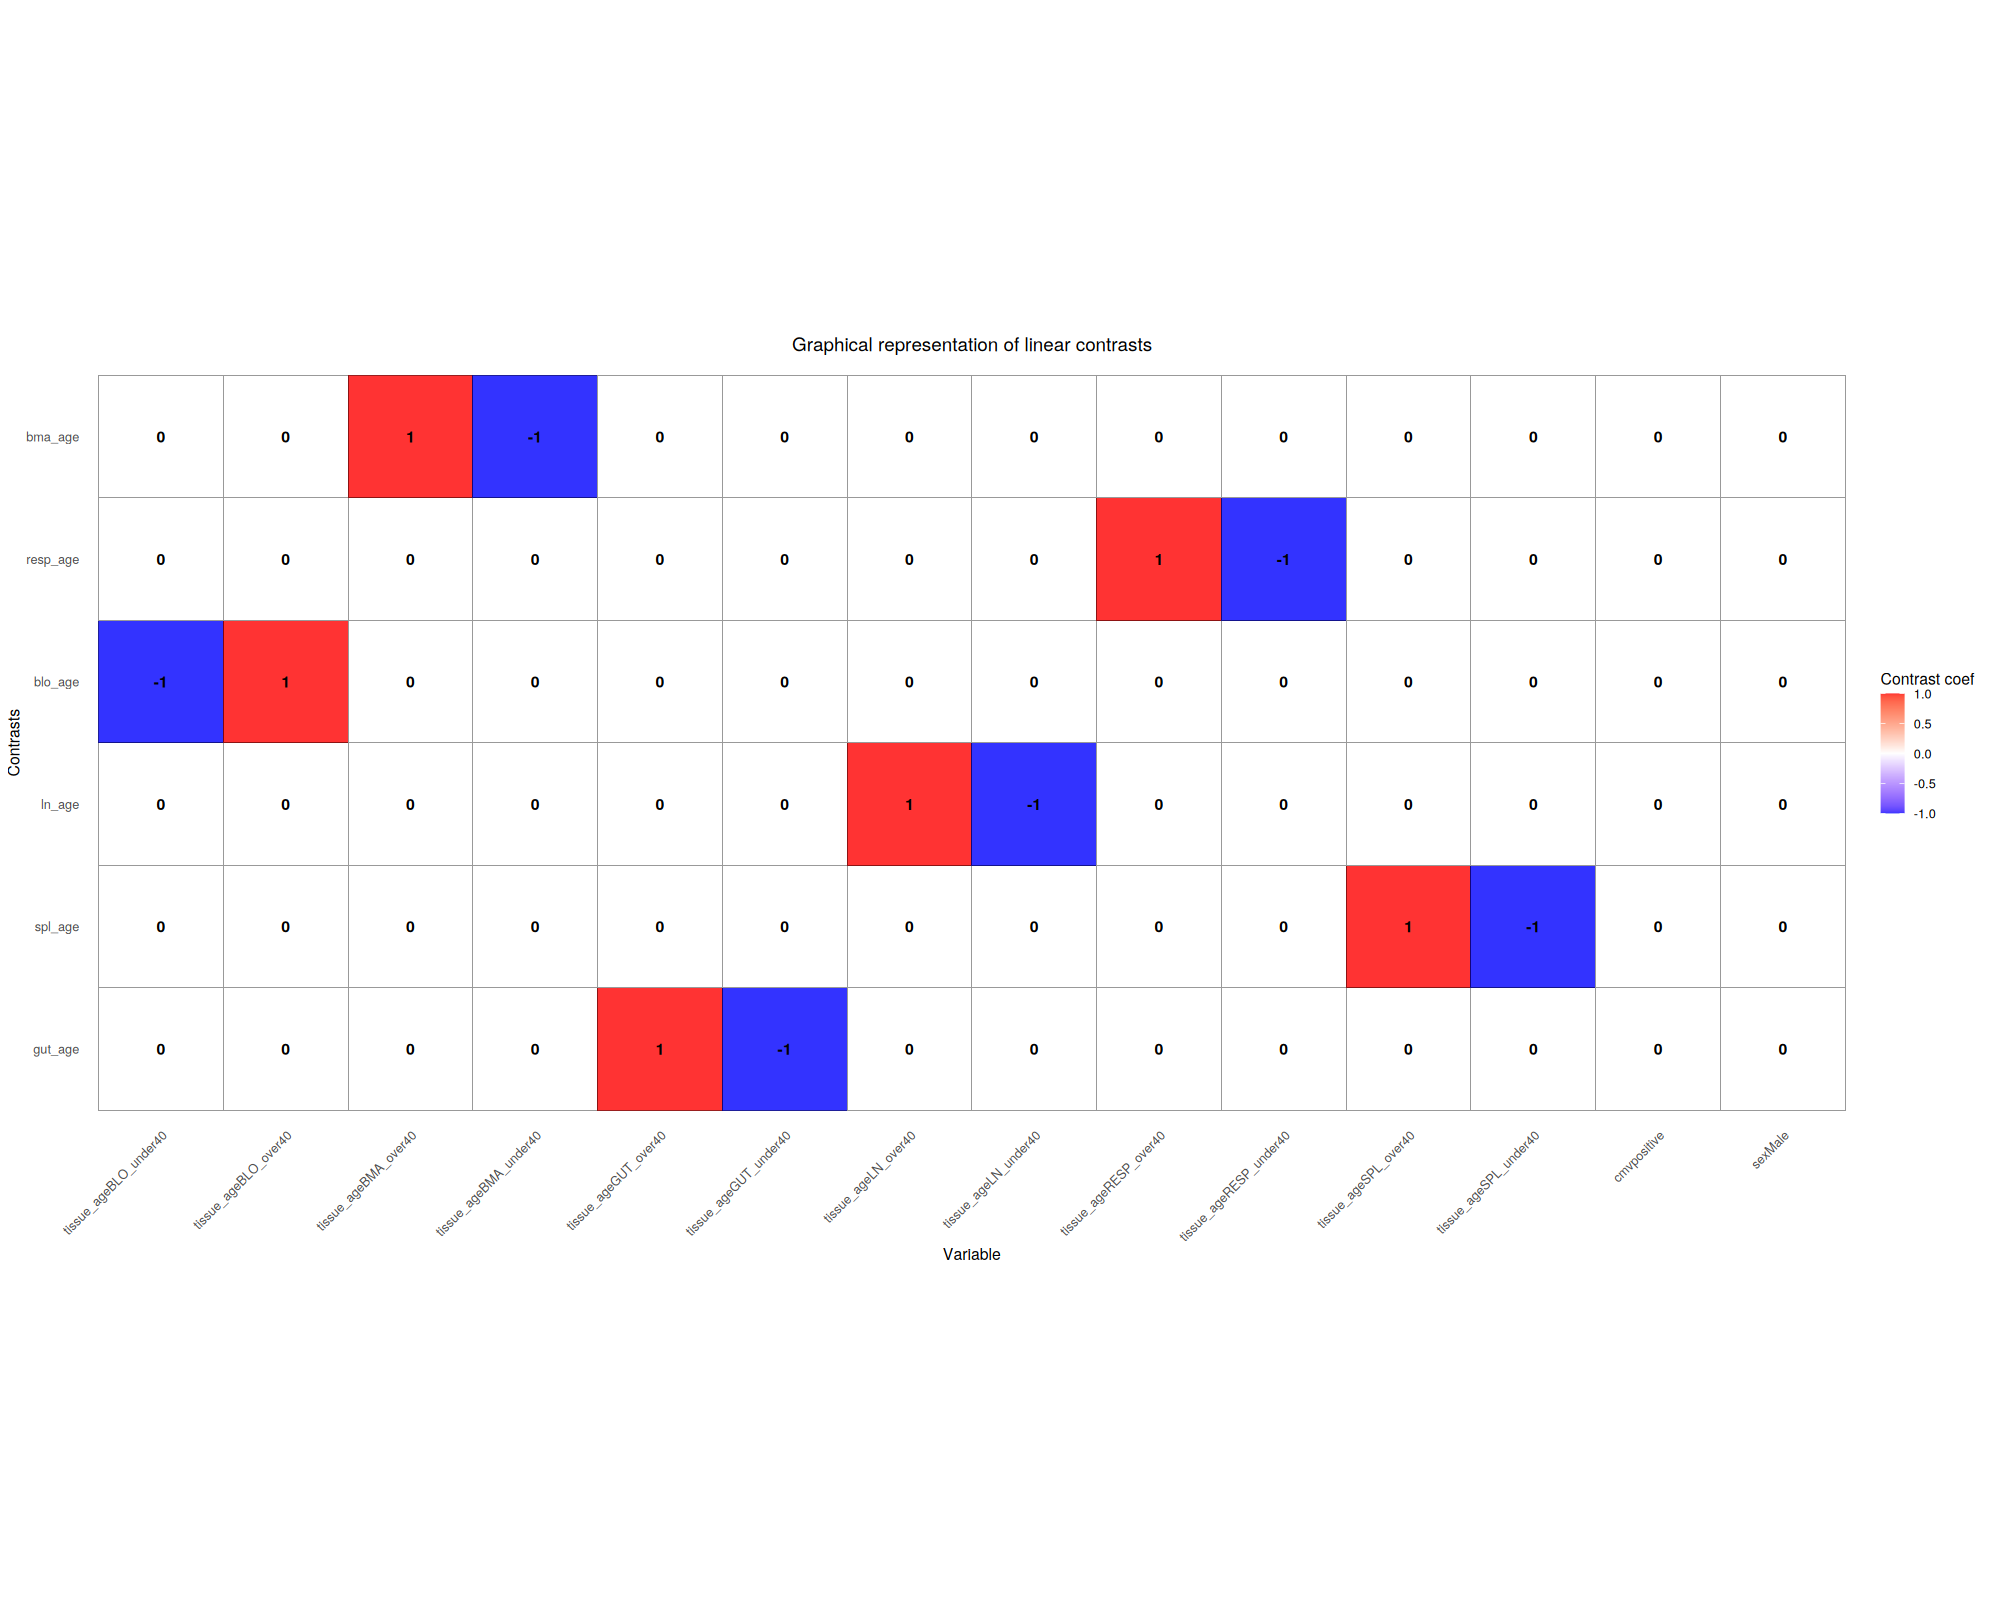

In [6]:
form <- ~ tissue_age + cmv + sex + (1|site) + 0

# Define contrasts
# Note that for each contrass, the weights sum to 1
L <- makeContrastsDream(form, colData(res.proc), contrasts = c(
    gut_age = "tissue_ageGUT_over40 - tissue_ageGUT_under40",
    spl_age = "tissue_ageSPL_over40 - tissue_ageSPL_under40",
    ln_age = "tissue_ageLN_over40 - tissue_ageLN_under40",
    blo_age = "tissue_ageBLO_over40 - tissue_ageBLO_under40",
    resp_age = "tissue_ageRESP_over40 - tissue_ageRESP_under40",
    bma_age = "tissue_ageBMA_over40 - tissue_ageBMA_under40")
)

plotContrasts(L)

In [7]:
form <- ~ tissue_age + cmv + sex + (1|site) + 0

# Differential expression analysis within each assay,
# evaluated on the voom normalized data
res.dl2 <- dreamlet(
    res.proc,
    form,
    assays=c('Lung mrVI LFC 0 normalized', 'Lung mrVI LFC 1 normalized', 'Lung mrVI LFC 2 normalized', 'Lung mrVI LFC 3 normalized'),
    colData(res.proc),
    contrasts = c(
        gut_age = "tissue_ageGUT_over40 - tissue_ageGUT_under40",
        spl_age = "tissue_ageSPL_over40 - tissue_ageSPL_under40",
        ln_age = "tissue_ageLN_over40 - tissue_ageLN_under40",
        blo_age = "tissue_ageBLO_over40 - tissue_ageBLO_under40",
        resp_age = "tissue_ageRESP_over40 - tissue_ageRESP_under40",
        bma_age = "tissue_ageBMA_over40 - tissue_ageBMA_under40"),
    computeResiduals=TRUE,
    BPPARAM=multicoreParam
)

# names of estimated coefficients
coefNames(res.dl2) 

  Lung mrVI LFC 0 normalized...
4.2 mins

  Lung mrVI LFC 1 normalized...
3.8 mins

  Lung mrVI LFC 2 normalized...
Warning message:
“makeContrastsDream: object 'tissue_ageGUT_over40' not found”
2.3 mins

  Lung mrVI LFC 3 normalized...
3.6 mins



[1] "gut_age"                "spl_age"                "ln_age"                
 [4] "blo_age"                "resp_age"               "bma_age"               
 [7] "tissue_ageBLO_under40"  "tissue_ageBLO_over40"   "tissue_ageBMA_over40"  
[10] "tissue_ageBMA_under40"  "tissue_ageGUT_over40"   "tissue_ageGUT_under40" 
[13] "tissue_ageLN_over40"    "tissue_ageLN_under40"   "tissue_ageRESP_over40" 
[16] "tissue_ageRESP_under40" "tissue_ageSPL_over40"   "tissue_ageSPL_under40" 
[19] "cmvpositive"            "sexMale"

In [34]:
library(dplyr)

table <- topTable(res.dl2, coef='resp_age', number=Inf)
# Extract the data as a standard data frame
standard_df <- as.data.frame(table)

# Filter the standard data frame
standard_df %>% filter(ID == "GZMK")

assay,ID,logFC,AveExpr,t,P.Value,adj.P.Val,B,z.std
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Lung mrVI LFC 2 normalized,GZMK,0.8517704,10.151583,2.2421722,0.02707068,0.1191644,-4.313575,2.2104971
Lung mrVI LFC 1 normalized,GZMK,1.4509754,5.215076,1.4595937,0.14630811,0.3420641,-4.719673,1.4526962
Lung mrVI LFC 0 normalized,GZMK,0.2154468,7.823684,0.4023335,0.68797241,0.8319992,-6.513717,0.4016082
Lung mrVI LFC 3 normalized,GZMK,-0.1205539,7.925904,-0.1785418,0.85852202,0.9299300,-6.096437,-0.1782559


Warning message:
“Removed 1 rows containing missing values (`geom_text_repel()`).”
Warning message:
“ggrepel: 66 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


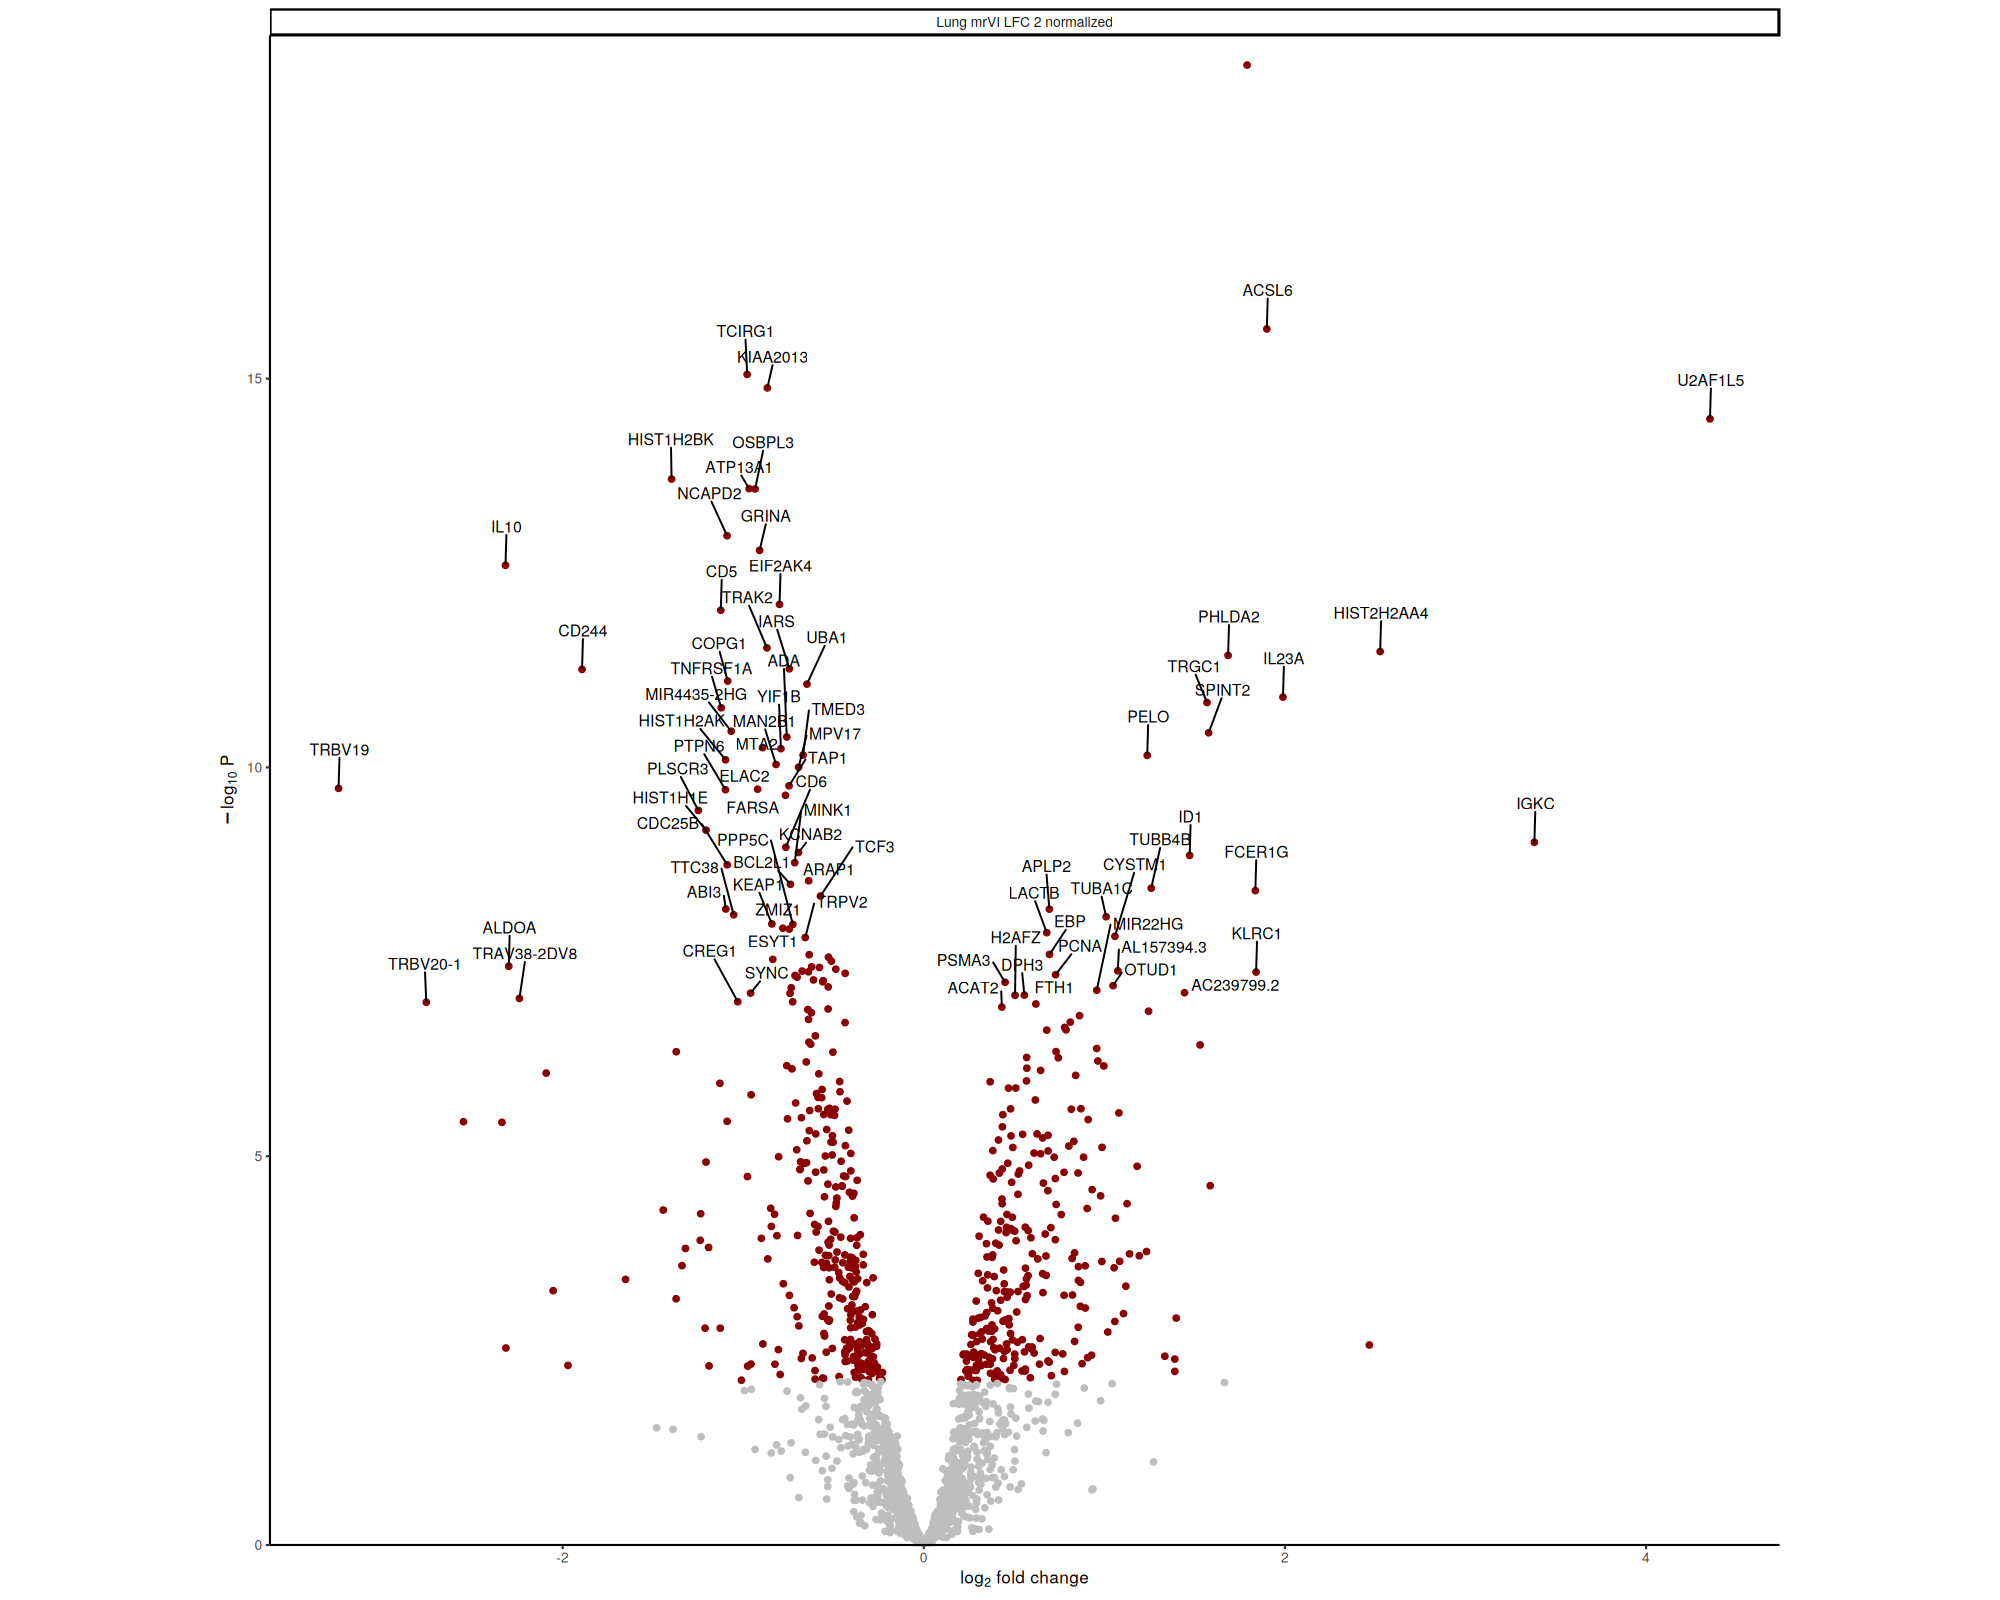

In [36]:
plotVolcano(res.dl2, coef='resp_age', nGenes=100, assay='Lung mrVI LFC 2 normalized')

In [37]:
for (i in c('gut_age', 'spl_age', 'ln_age', 'blo_age', 'resp_age', 'bma_age')){
    table <- topTable(res.dl2, coef=i, number=Inf)
    write.csv(table, paste0("results_dreamlet_mrvi/lung_", i, "_random.csv"))
}

# Gut

## Preprocess

In [46]:
pb <- aggregateToPseudoBulk(
    sce,
    assay = "counts",
    cluster_id = "Gut.Module.Consensus.Redo",
    sample_id = "donor_tissue",
    verbose = TRUE)
# one 'assay' per cell type
assayNames(pb)
rownames(pb) <- rowData(sce)$genes
saveRDS(pb, file='pseudobulk_mrvi_gut.rds')

[1] "Gut mrVI LFC 0 normalized" "Gut mrVI LFC 1 normalized"
[3] "Gut mrVI LFC 2 normalized" "Gut mrVI LFC 3 normalized"
[5] "IL17A"                     "other"

In [47]:
library(BiocParallel)
multicoreParam <- MulticoreParam(workers = 8)
multicoreParam

class: MulticoreParam
  bpisup: FALSE; bpnworkers: 8; bptasks: 0; bpjobname: BPJOB
  bplog: FALSE; bpthreshold: INFO; bpstopOnError: TRUE
  bpRNGseed: ; bptimeout: NA; bpprogressbar: FALSE
  bpexportglobals: TRUE; bpexportvariables: FALSE; bpforceGC: FALSE
  bpfallback: TRUE
  bplogdir: NA
  bpresultdir: NA
  cluster type: FORK

In [48]:
rownames(pb) <- rowData(pb)$gene_names

In [49]:
# Normalize and apply voom/voomWithDreamWeights
res.proc = processAssays( pb, ~ tissue + cmv + age_group + sex + chemistry + site + 0, min.cells=10, min.count=5, min.prop=0.1, BPPARAM=multicoreParam)

# the resulting object of class dreamletProcessedData stores
# normalized data and other information
res.proc

  Gut mrVI LFC 0 normalized...
0.51 secs

  Gut mrVI LFC 1 normalized...
0.42 secs

  Gut mrVI LFC 2 normalized...
0.54 secs

  Gut mrVI LFC 3 normalized...
0.85 secs

  IL17A...
0.92 secs

  other...
1.6 secs



class: dreamletProcessedData 
assays(6): Gut mrVI LFC 0 normalized Gut mrVI LFC 1 normalized ...
  IL17A other
colData(23): donor site ... tissue_groups tissue_age
metadata(45): Gut.Module.Consensus.Redo donor_tissue ...
  LN.mrVI.LFC.2.filtered LN.mrVI.LFC.3.filtered
Samples:
 min: 58 
 max: 178
Genes:
 min: 1579 
 max: 3686 
details(7): assay n_retain ... n_errors error_initial

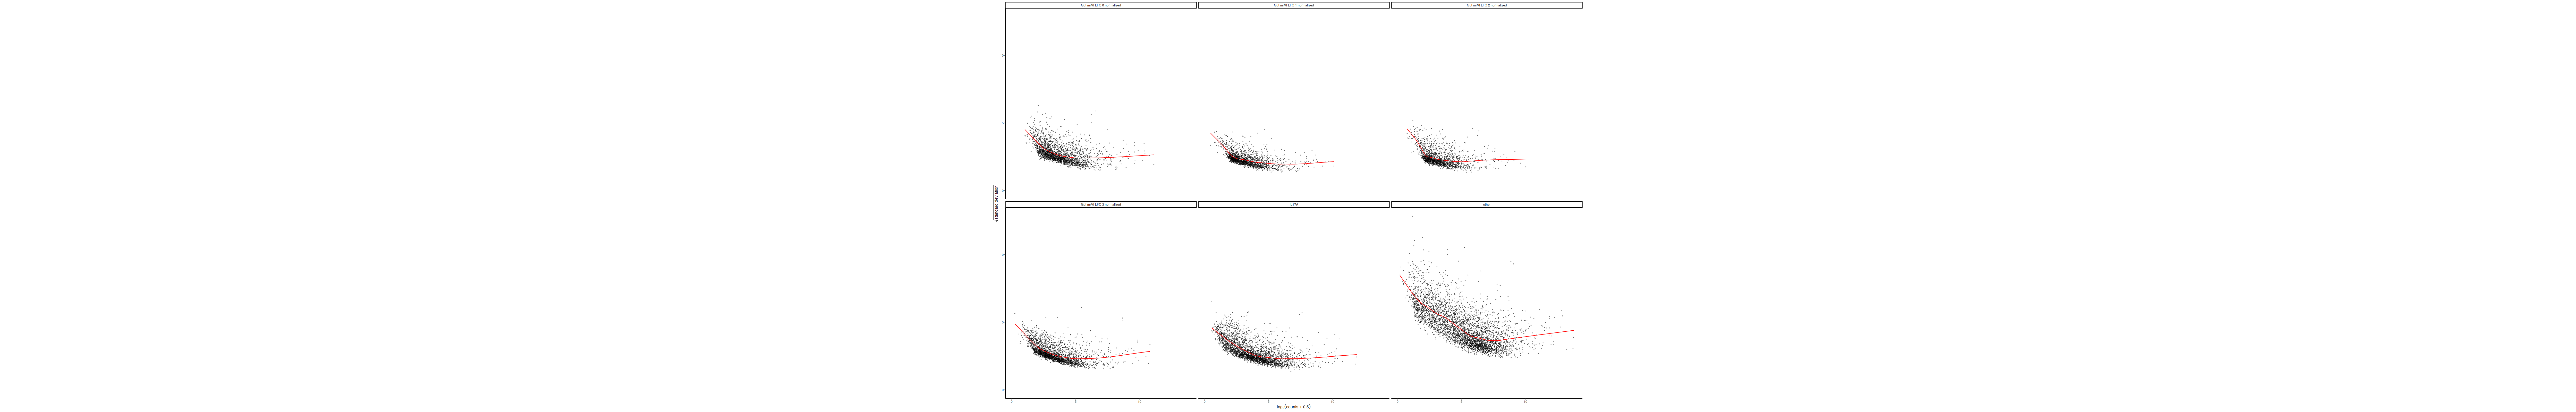

In [50]:
# show voom plot for each cell clusters 
options(repr.plot.width = 100, repr.plot.height = 16, repr.plot.res = 100)
plotVoom(res.proc)

In [51]:
saveRDS(res.proc, file='pseudobulk_mrvi_gut_preprocessed.rds')

## DE test aging

In [40]:
res.proc <- readRDS(file='pseudobulk_mrvi_gut_preprocessed.rds')

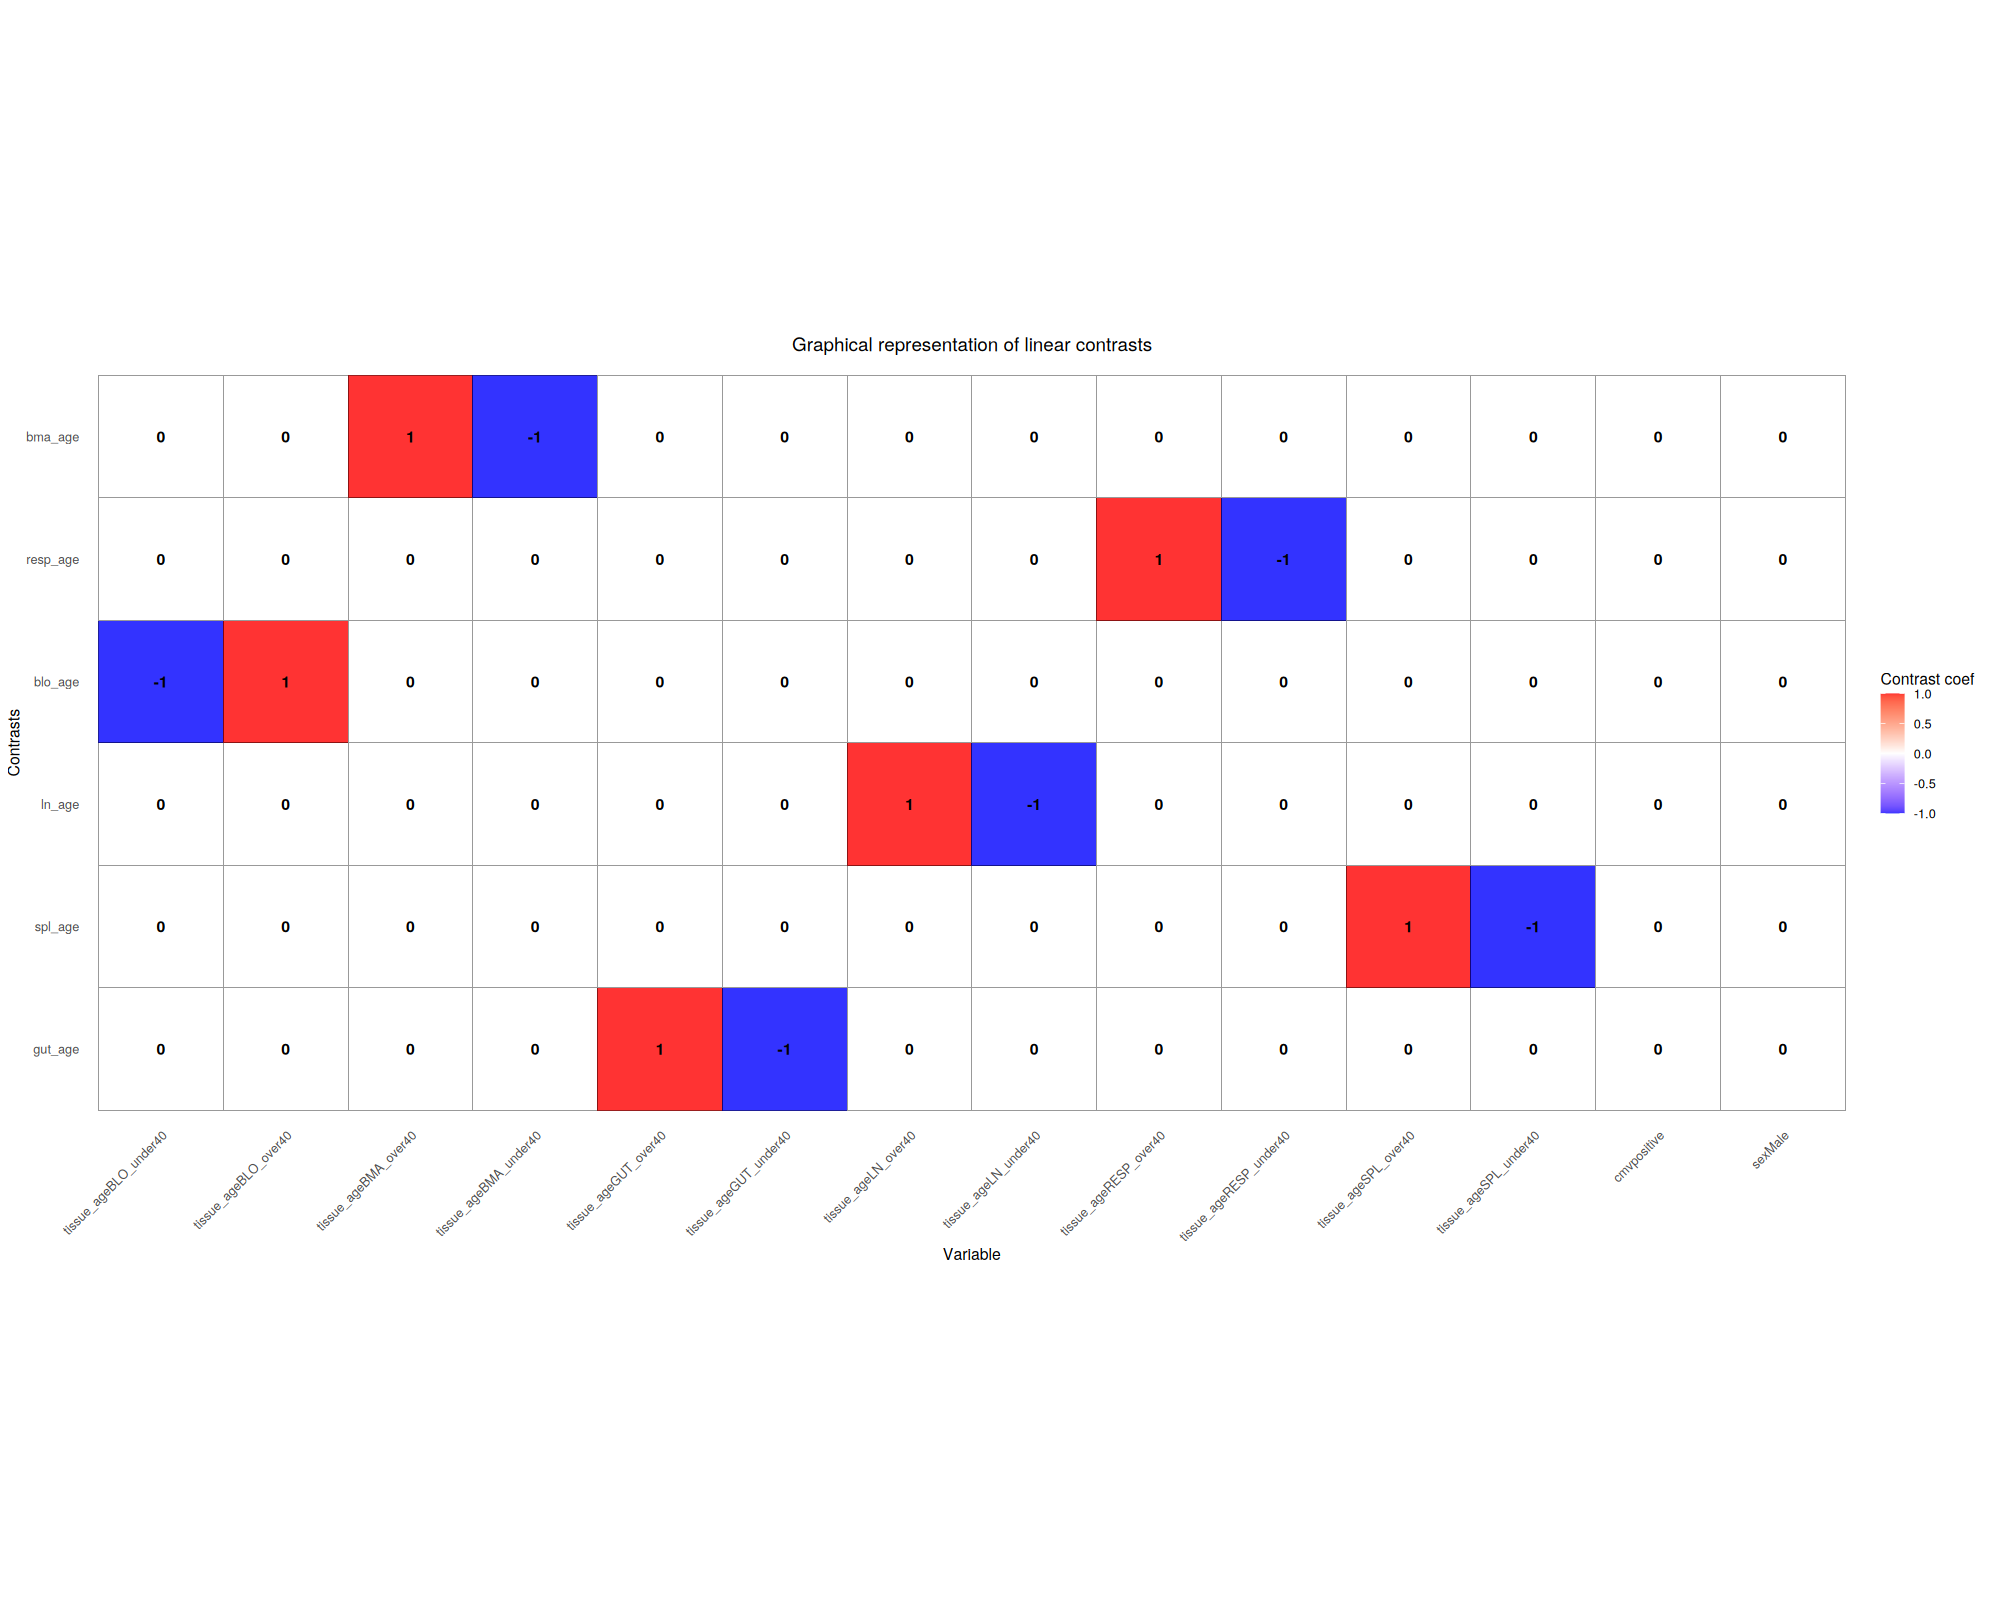

In [41]:
form <- ~ tissue_age + cmv + sex + (1|site) + 0

# Define contrasts
# Note that for each contrass, the weights sum to 1
L <- makeContrastsDream(form, colData(res.proc), contrasts = c(
    gut_age = "tissue_ageGUT_over40 - tissue_ageGUT_under40",
    spl_age = "tissue_ageSPL_over40 - tissue_ageSPL_under40",
    ln_age = "tissue_ageLN_over40 - tissue_ageLN_under40",
    blo_age = "tissue_ageBLO_over40 - tissue_ageBLO_under40",
    resp_age = "tissue_ageRESP_over40 - tissue_ageRESP_under40",
    bma_age = "tissue_ageBMA_over40 - tissue_ageBMA_under40")
)

plotContrasts(L)

In [42]:
form <- ~ tissue_age + cmv + sex + (1|site) + 0

# Differential expression analysis within each assay,
# evaluated on the voom normalized data
res.dl2 <- dreamlet(
    res.proc,
    form,
    assays=c('Gut mrVI LFC 0 normalized', 'Gut mrVI LFC 1 normalized', 'Gut mrVI LFC 2 normalized', 'Gut mrVI LFC 3 normalized', 'IL17A'),
    colData(res.proc),
    contrasts = c(
        gut_age = "tissue_ageGUT_over40 - tissue_ageGUT_under40",
        spl_age = "tissue_ageSPL_over40 - tissue_ageSPL_under40",
        ln_age = "tissue_ageLN_over40 - tissue_ageLN_under40",
        blo_age = "tissue_ageBLO_over40 - tissue_ageBLO_under40",
        resp_age = "tissue_ageRESP_over40 - tissue_ageRESP_under40",
        bma_age = "tissue_ageBMA_over40 - tissue_ageBMA_under40"),
    computeResiduals=TRUE,
    BPPARAM=multicoreParam
)

# names of estimated coefficients
coefNames(res.dl2) 

  Gut mrVI LFC 0 normalized...
Warning message:
“makeContrastsDream: object 'tissue_ageSPL_under40' not found”
Warning message:
“makeContrastsDream: object 'tissue_ageLN_over40' not found”
Warning message:
“makeContrastsDream: object 'tissue_ageRESP_over40' not found”
2.7 mins

  Gut mrVI LFC 1 normalized...
Warning message:
“makeContrastsDream: object 'tissue_ageLN_over40' not found”
Warning message:
“makeContrastsDream: object 'tissue_ageRESP_over40' not found”
2 mins

  Gut mrVI LFC 2 normalized...
Warning message:
“makeContrastsDream: object 'tissue_ageLN_over40' not found”
Warning message:
“makeContrastsDream: object 'tissue_ageRESP_over40' not found”
2 mins

  Gut mrVI LFC 3 normalized...
Warning message:
“makeContrastsDream: object 'tissue_ageRESP_over40' not found”
3.1 mins

  IL17A...
Warning message:
“makeContrastsDream: object 'tissue_ageSPL_over40' not found”
Warning message:
“makeContrastsDream: object 'tissue_ageBMA_over40' not found”
3.5 mins


Of 10,501 models fit acros

[1] "gut_age"                "blo_age"                "bma_age"               
 [4] "tissue_ageBLO_under40"  "tissue_ageBLO_over40"   "tissue_ageBMA_over40"  
 [7] "tissue_ageBMA_under40"  "tissue_ageGUT_over40"   "tissue_ageGUT_under40" 
[10] "tissue_ageSPL_over40"   "cmvpositive"            "sexMale"               
[13] "spl_age"                "tissue_ageSPL_under40"  "ln_age"                
[16] "tissue_ageLN_over40"    "tissue_ageLN_under40"   "resp_age"              
[19] "tissue_ageRESP_over40"  "tissue_ageRESP_under40"

Warning message:
“Removed 2 rows containing missing values (`geom_text_repel()`).”
Warning message:
“ggrepel: 45 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


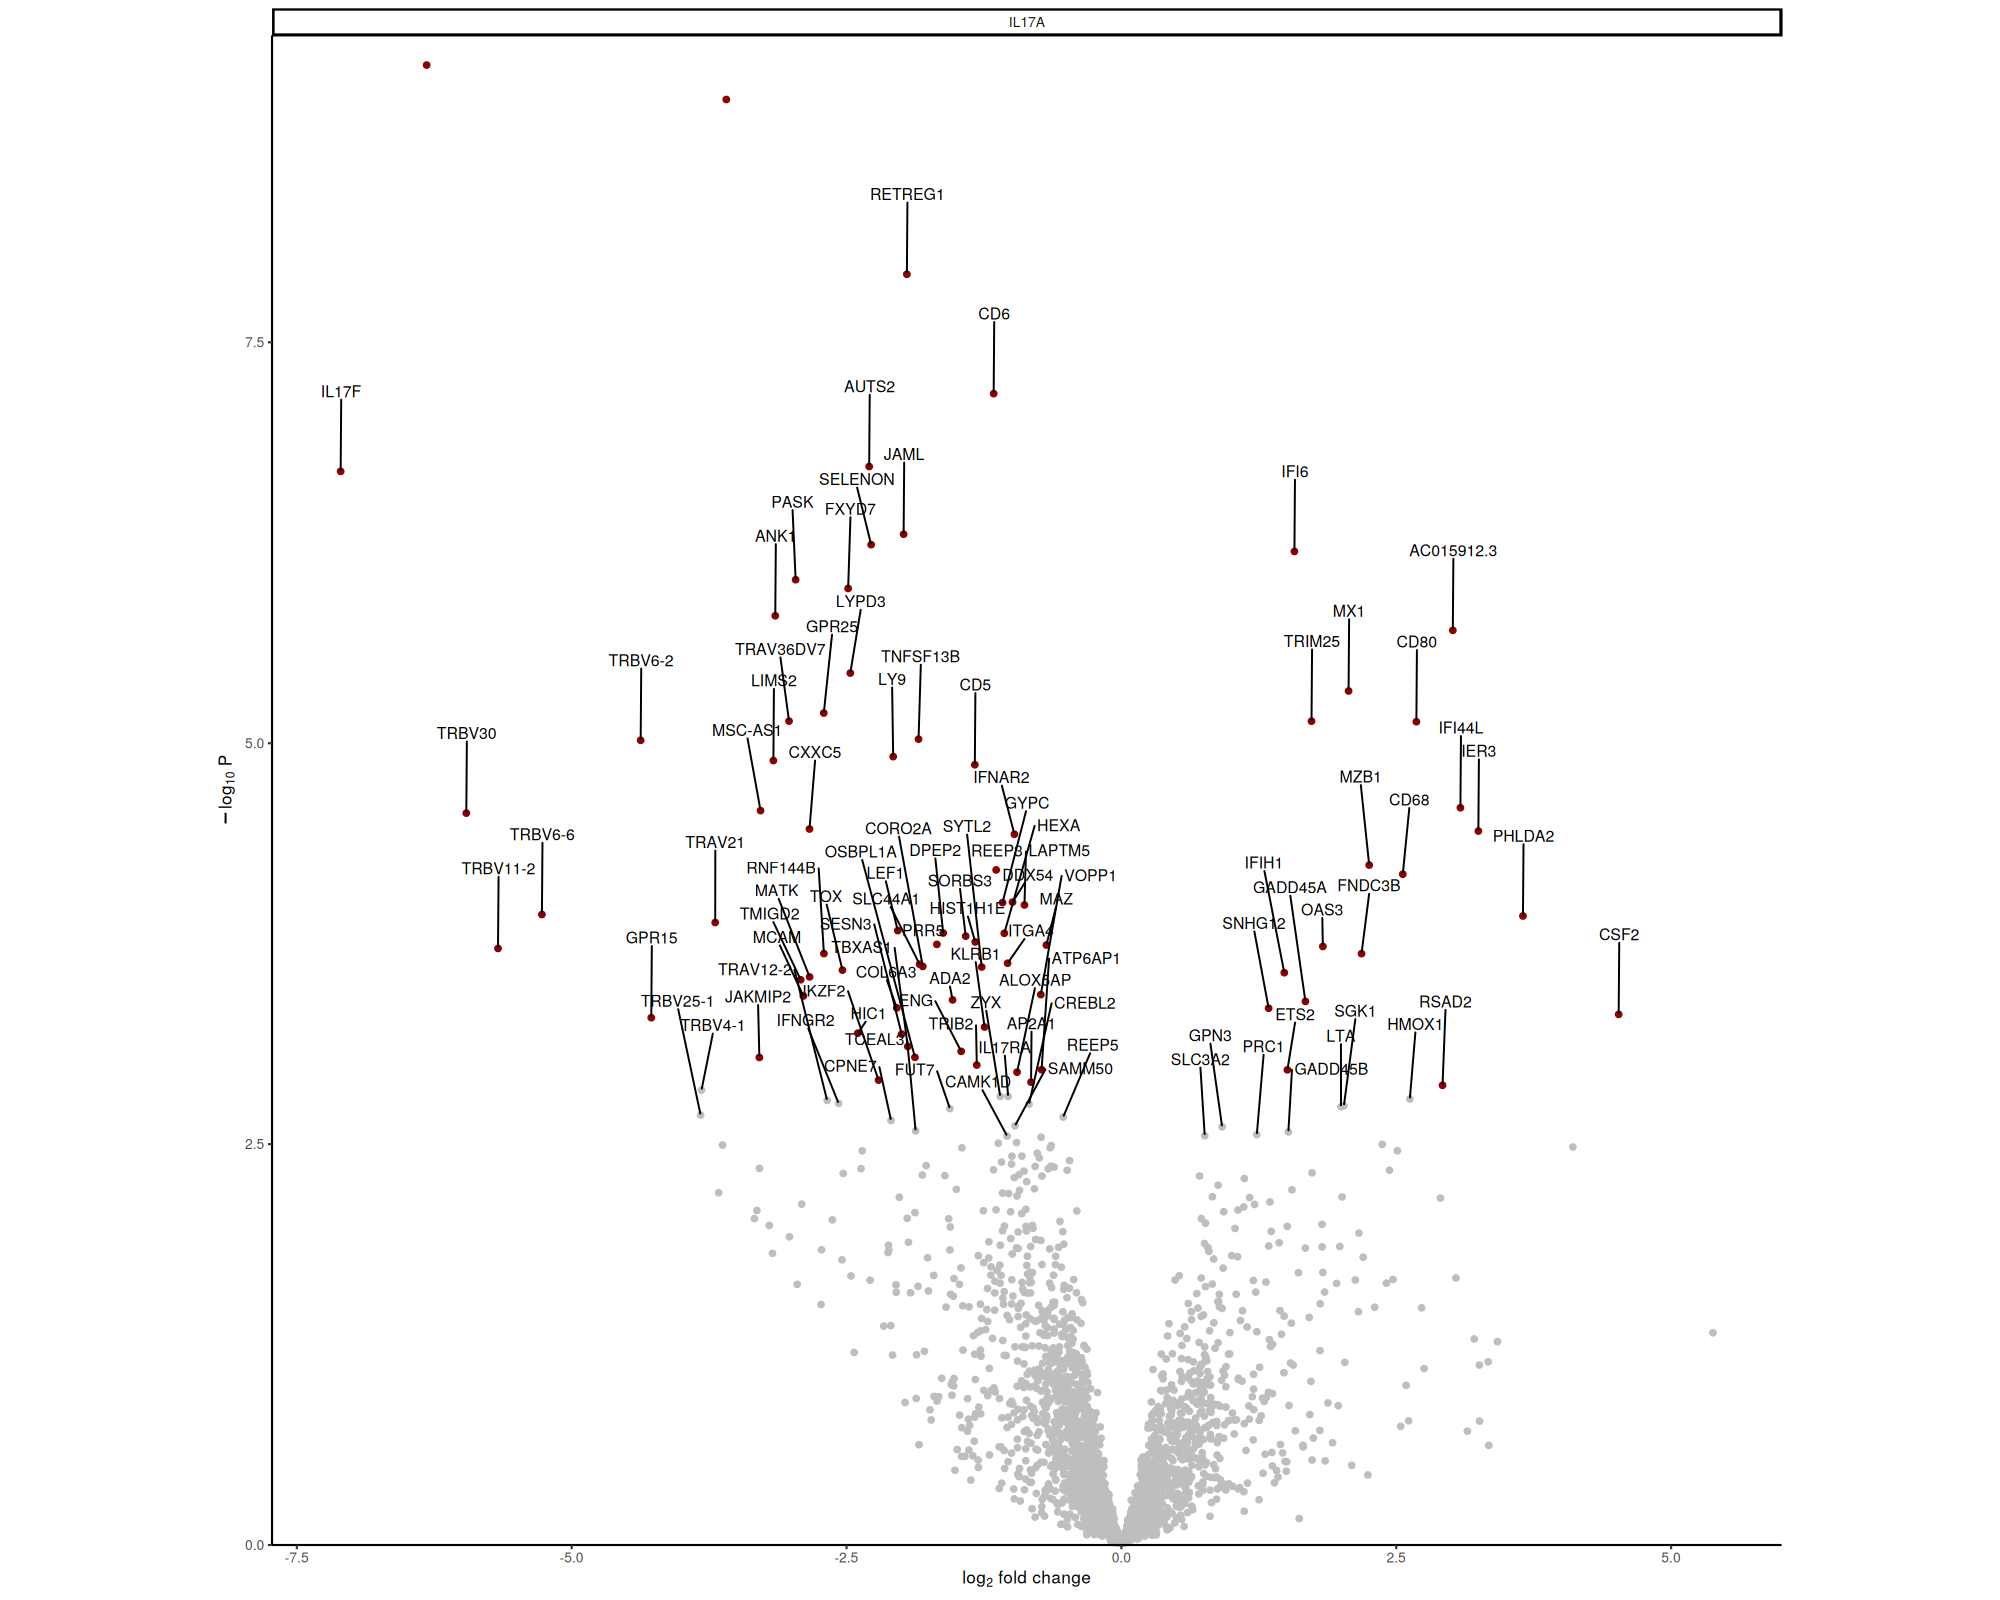

In [43]:
plotVolcano(res.dl2, coef='resp_age', nGenes=100, assay='IL17A')

In [44]:
for (i in c('gut_age', 'spl_age', 'ln_age', 'blo_age', 'resp_age', 'bma_age')){
    table <- topTable(res.dl2, coef=i, number=Inf)
    write.csv(table, paste0("results_dreamlet_mrvi/gut_", i, "_random.csv"))
}

# LN

## Preprocess

In [64]:
pb <- aggregateToPseudoBulk(
    sce,
    assay = "counts",
    cluster_id = "LN.Module.Consensus",
    sample_id = "donor_tissue",
    verbose = TRUE)
# one 'assay' per cell type
assayNames(pb)
rownames(pb) <- rowData(sce)$genes
saveRDS(pb, file='pseudobulk_mrvi_ln.rds')

[1] "LN mrVI LFC 0 normalized" "LN mrVI LFC 1 normalized"
[3] "LN mrVI LFC 2 normalized" "LN mrVI LFC 3 normalized"
[5] "other"

In [65]:
library(BiocParallel)
multicoreParam <- MulticoreParam(workers = 8)
multicoreParam

class: MulticoreParam
  bpisup: FALSE; bpnworkers: 8; bptasks: 0; bpjobname: BPJOB
  bplog: FALSE; bpthreshold: INFO; bpstopOnError: TRUE
  bpRNGseed: ; bptimeout: NA; bpprogressbar: FALSE
  bpexportglobals: TRUE; bpexportvariables: FALSE; bpforceGC: FALSE
  bpfallback: TRUE
  bplogdir: NA
  bpresultdir: NA
  cluster type: FORK

In [66]:
rownames(pb) <- rowData(pb)$gene_names

In [67]:
# Normalize and apply voom/voomWithDreamWeights
res.proc = processAssays( pb, ~ tissue + cmv + age_group + sex + chemistry + site + 0, min.cells=10, min.count=5, min.prop=0.1, BPPARAM=multicoreParam)

# the resulting object of class dreamletProcessedData stores
# normalized data and other information
res.proc

  LN mrVI LFC 0 normalized...
0.81 secs

  LN mrVI LFC 1 normalized...
1.1 secs

  LN mrVI LFC 2 normalized...
1.4 secs

  LN mrVI LFC 3 normalized...
1.2 secs

  other...
1.6 secs



class: dreamletProcessedData 
assays(5): LN mrVI LFC 0 normalized LN mrVI LFC 1 normalized LN mrVI
  LFC 2 normalized LN mrVI LFC 3 normalized other
colData(23): donor site ... tissue_groups tissue_age
metadata(45): LN.Module.Consensus donor_tissue ...
  LN.mrVI.LFC.2.filtered LN.mrVI.LFC.3.filtered
Samples:
 min: 83 
 max: 177
Genes:
 min: 2832 
 max: 3439 
details(7): assay n_retain ... n_errors error_initial

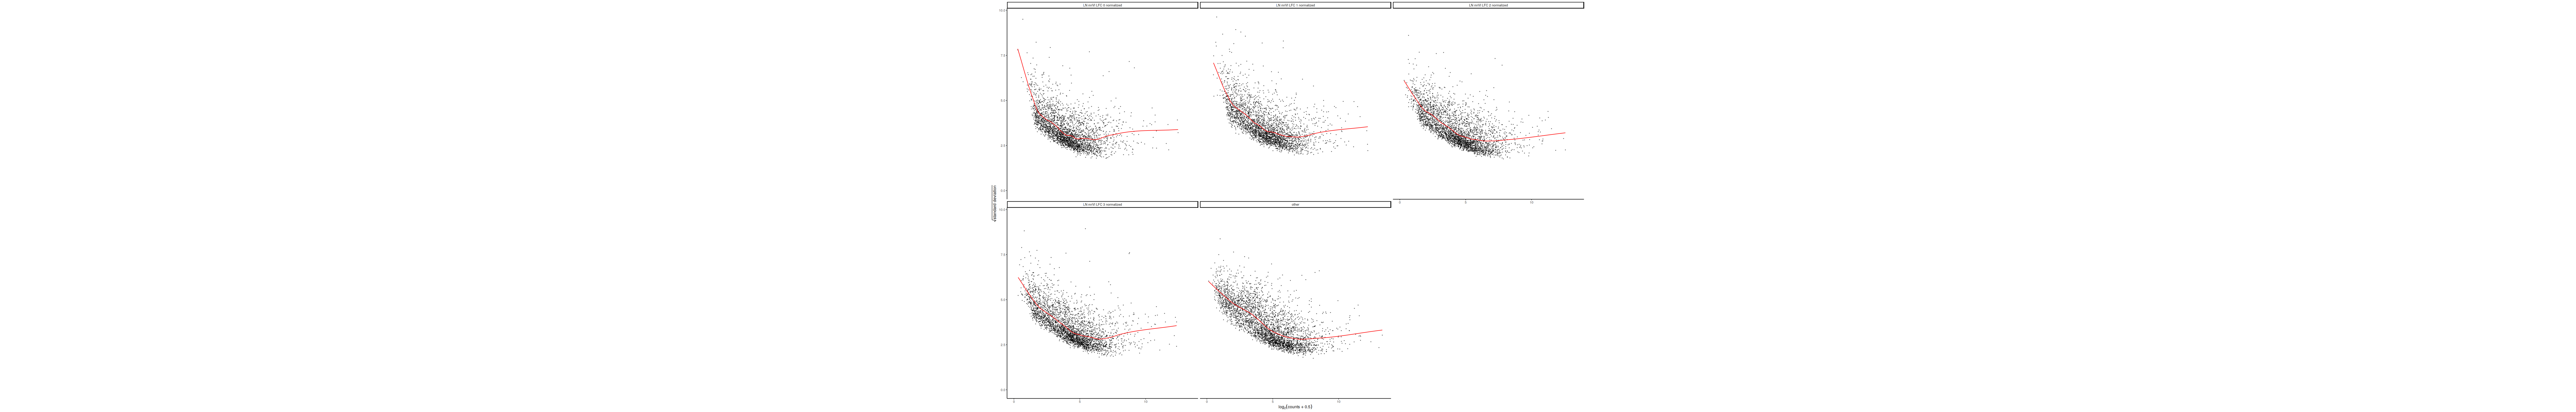

In [68]:
# show voom plot for each cell clusters 
options(repr.plot.width = 100, repr.plot.height = 16, repr.plot.res = 100)
plotVoom(res.proc)

In [69]:
saveRDS(res.proc, file='pseudobulk_mrvi_ln_preprocessed.rds')

## DE test aging

In [45]:
res.proc <- readRDS(file='pseudobulk_mrvi_ln_preprocessed.rds')

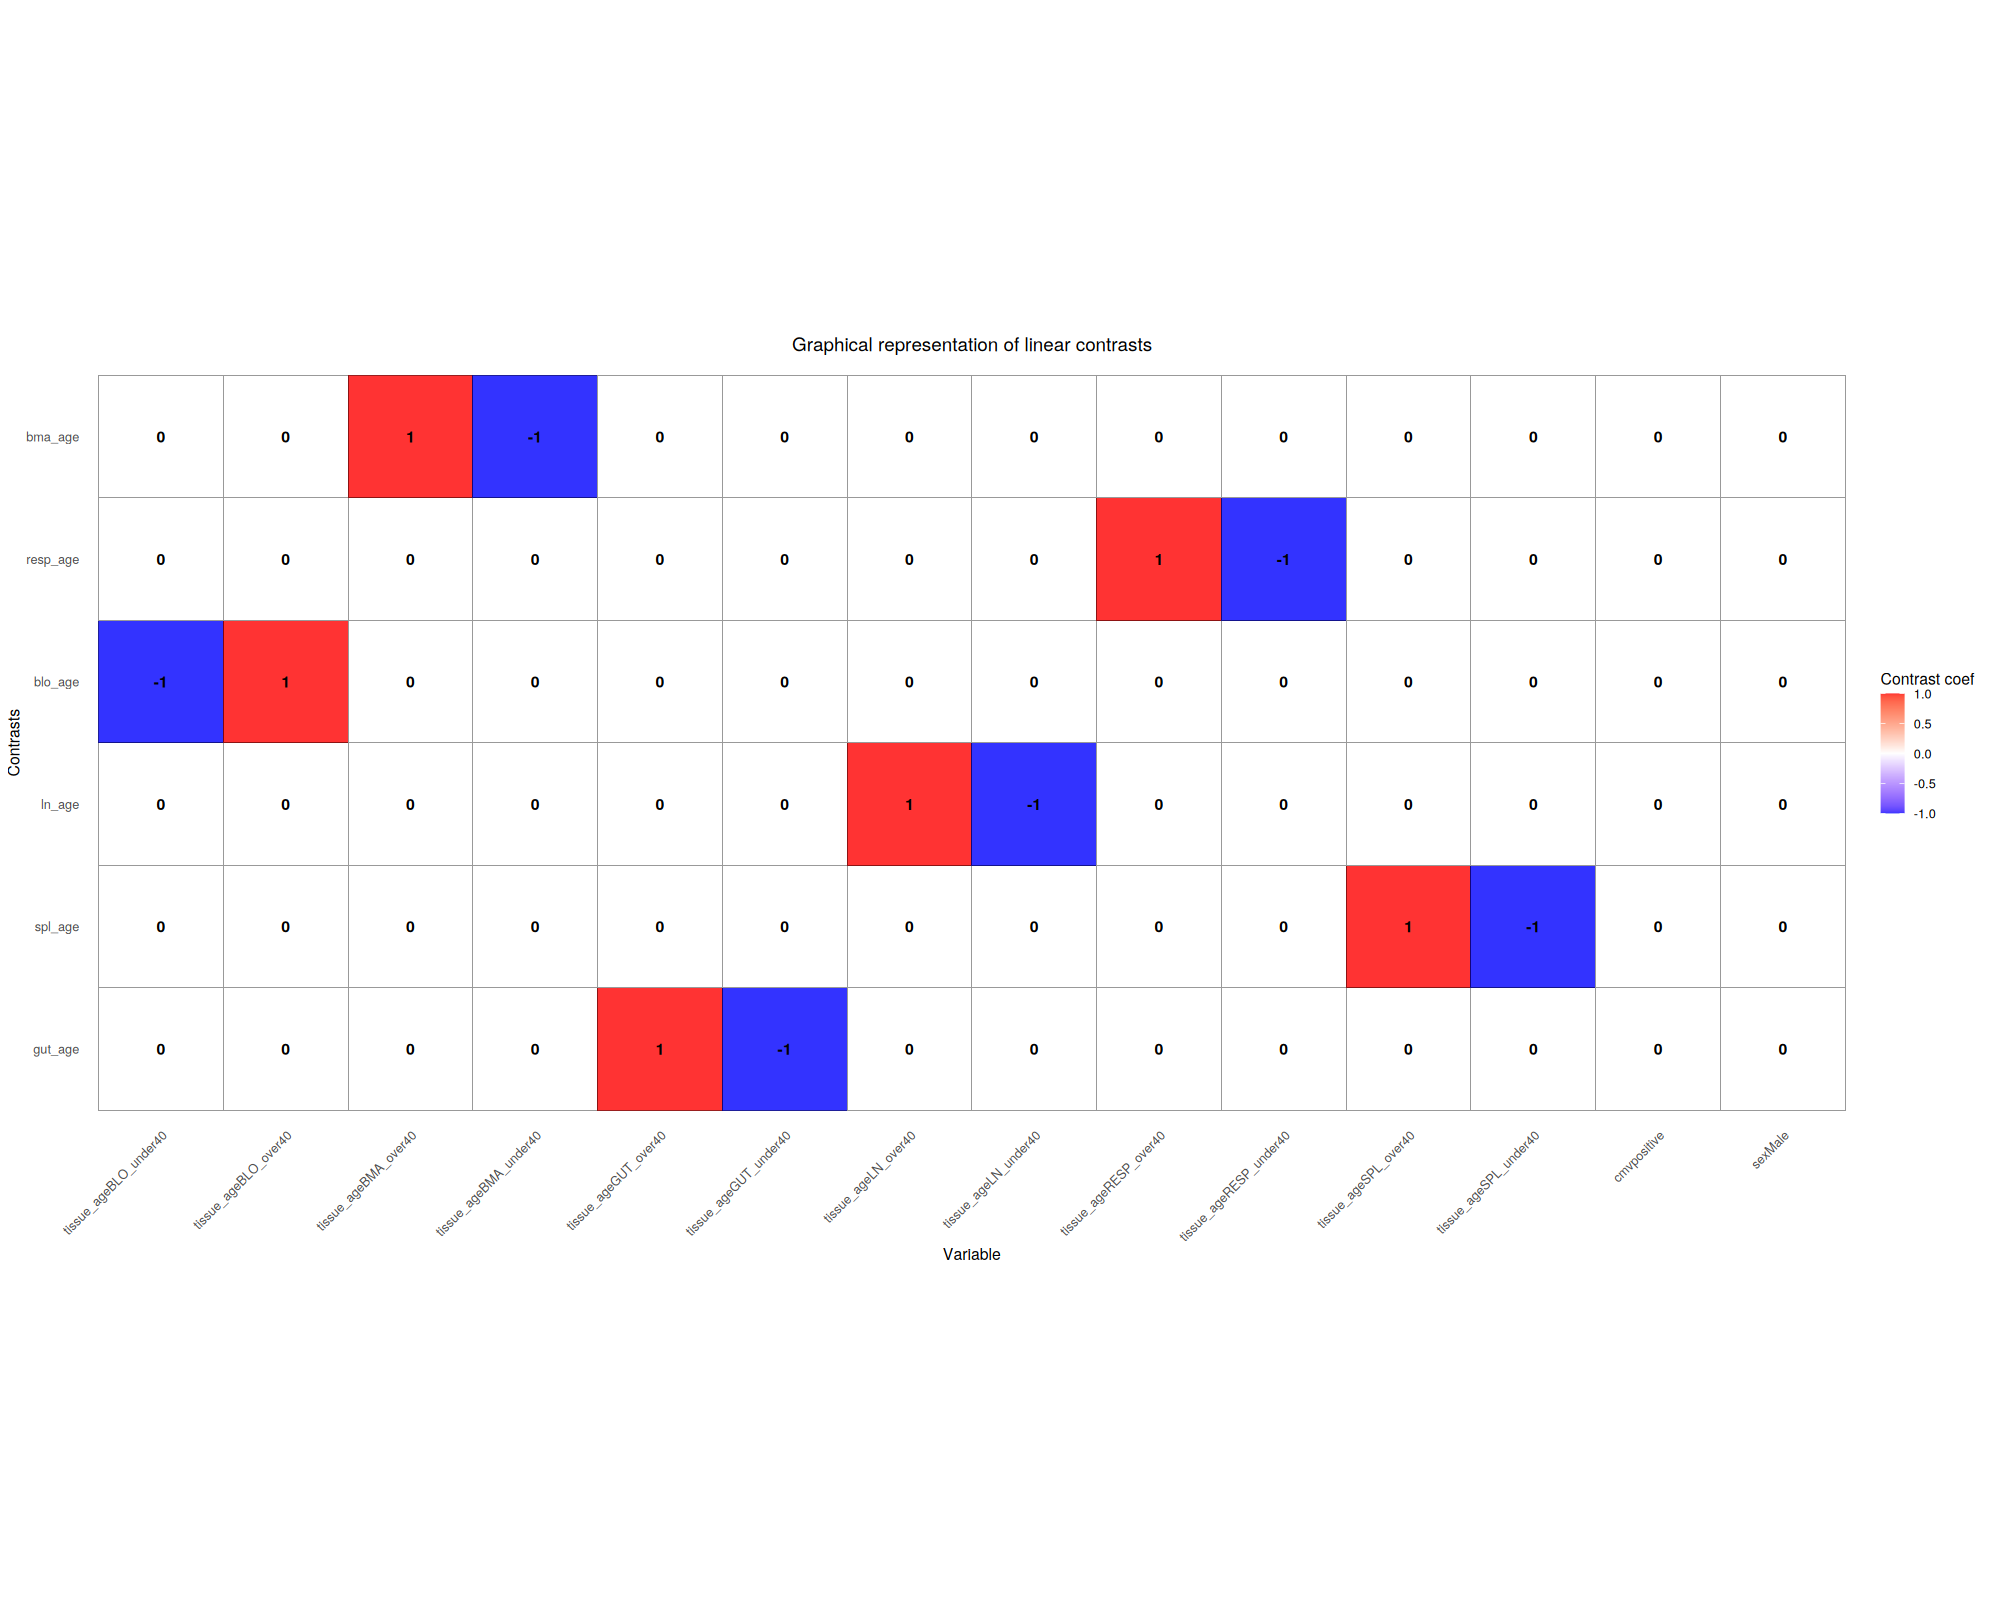

In [46]:
form <- ~ tissue_age + cmv + sex + (1|site) + 0

# Define contrasts
# Note that for each contrass, the weights sum to 1
L <- makeContrastsDream(form, colData(res.proc), contrasts = c(
    gut_age = "tissue_ageGUT_over40 - tissue_ageGUT_under40",
    spl_age = "tissue_ageSPL_over40 - tissue_ageSPL_under40",
    ln_age = "tissue_ageLN_over40 - tissue_ageLN_under40",
    blo_age = "tissue_ageBLO_over40 - tissue_ageBLO_under40",
    resp_age = "tissue_ageRESP_over40 - tissue_ageRESP_under40",
    bma_age = "tissue_ageBMA_over40 - tissue_ageBMA_under40")
)

plotContrasts(L)

In [47]:
form <- ~ tissue_age + cmv + sex + (1|site) + 0

# Differential expression analysis within each assay,
# evaluated on the voom normalized data
res.dl2 <- dreamlet(
    res.proc,
    form,
    assays=c('LN mrVI LFC 0 normalized', 'LN mrVI LFC 1 normalized', 'LN mrVI LFC 2 normalized', 'LN mrVI LFC 3 normalized'),
    colData(res.proc),
    contrasts = c(
        gut_age = "tissue_ageGUT_over40 - tissue_ageGUT_under40",
        spl_age = "tissue_ageSPL_over40 - tissue_ageSPL_under40",
        ln_age = "tissue_ageLN_over40 - tissue_ageLN_under40",
        blo_age = "tissue_ageBLO_over40 - tissue_ageBLO_under40",
        resp_age = "tissue_ageRESP_over40 - tissue_ageRESP_under40",
        bma_age = "tissue_ageBMA_over40 - tissue_ageBMA_under40"),
    computeResiduals=TRUE,
    BPPARAM=multicoreParam
)

# names of estimated coefficients
coefNames(res.dl2) 

  LN mrVI LFC 0 normalized...
Warning message:
“makeContrastsDream: object 'tissue_ageGUT_over40' not found”
Warning message:
“makeContrastsDream: object 'tissue_ageBLO_over40' not found”
3.4 mins

  LN mrVI LFC 1 normalized...
Warning message:
“makeContrastsDream: object 'tissue_ageGUT_over40' not found”
3.6 mins

  LN mrVI LFC 2 normalized...
4 mins

  LN mrVI LFC 3 normalized...
Warning message:
“makeContrastsDream: object 'tissue_ageRESP_over40' not found”
3.9 mins



[1] "spl_age"                "ln_age"                 "resp_age"              
 [4] "bma_age"                "tissue_ageBMA_over40"   "tissue_ageBMA_under40" 
 [7] "tissue_ageLN_over40"    "tissue_ageLN_under40"   "tissue_ageRESP_over40" 
[10] "tissue_ageRESP_under40" "tissue_ageSPL_over40"   "tissue_ageSPL_under40" 
[13] "cmvpositive"            "sexMale"                "blo_age"               
[16] "tissue_ageBLO_under40"  "tissue_ageBLO_over40"   "gut_age"               
[19] "tissue_ageGUT_over40"   "tissue_ageGUT_under40"

Warning message:
“ggrepel: 72 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


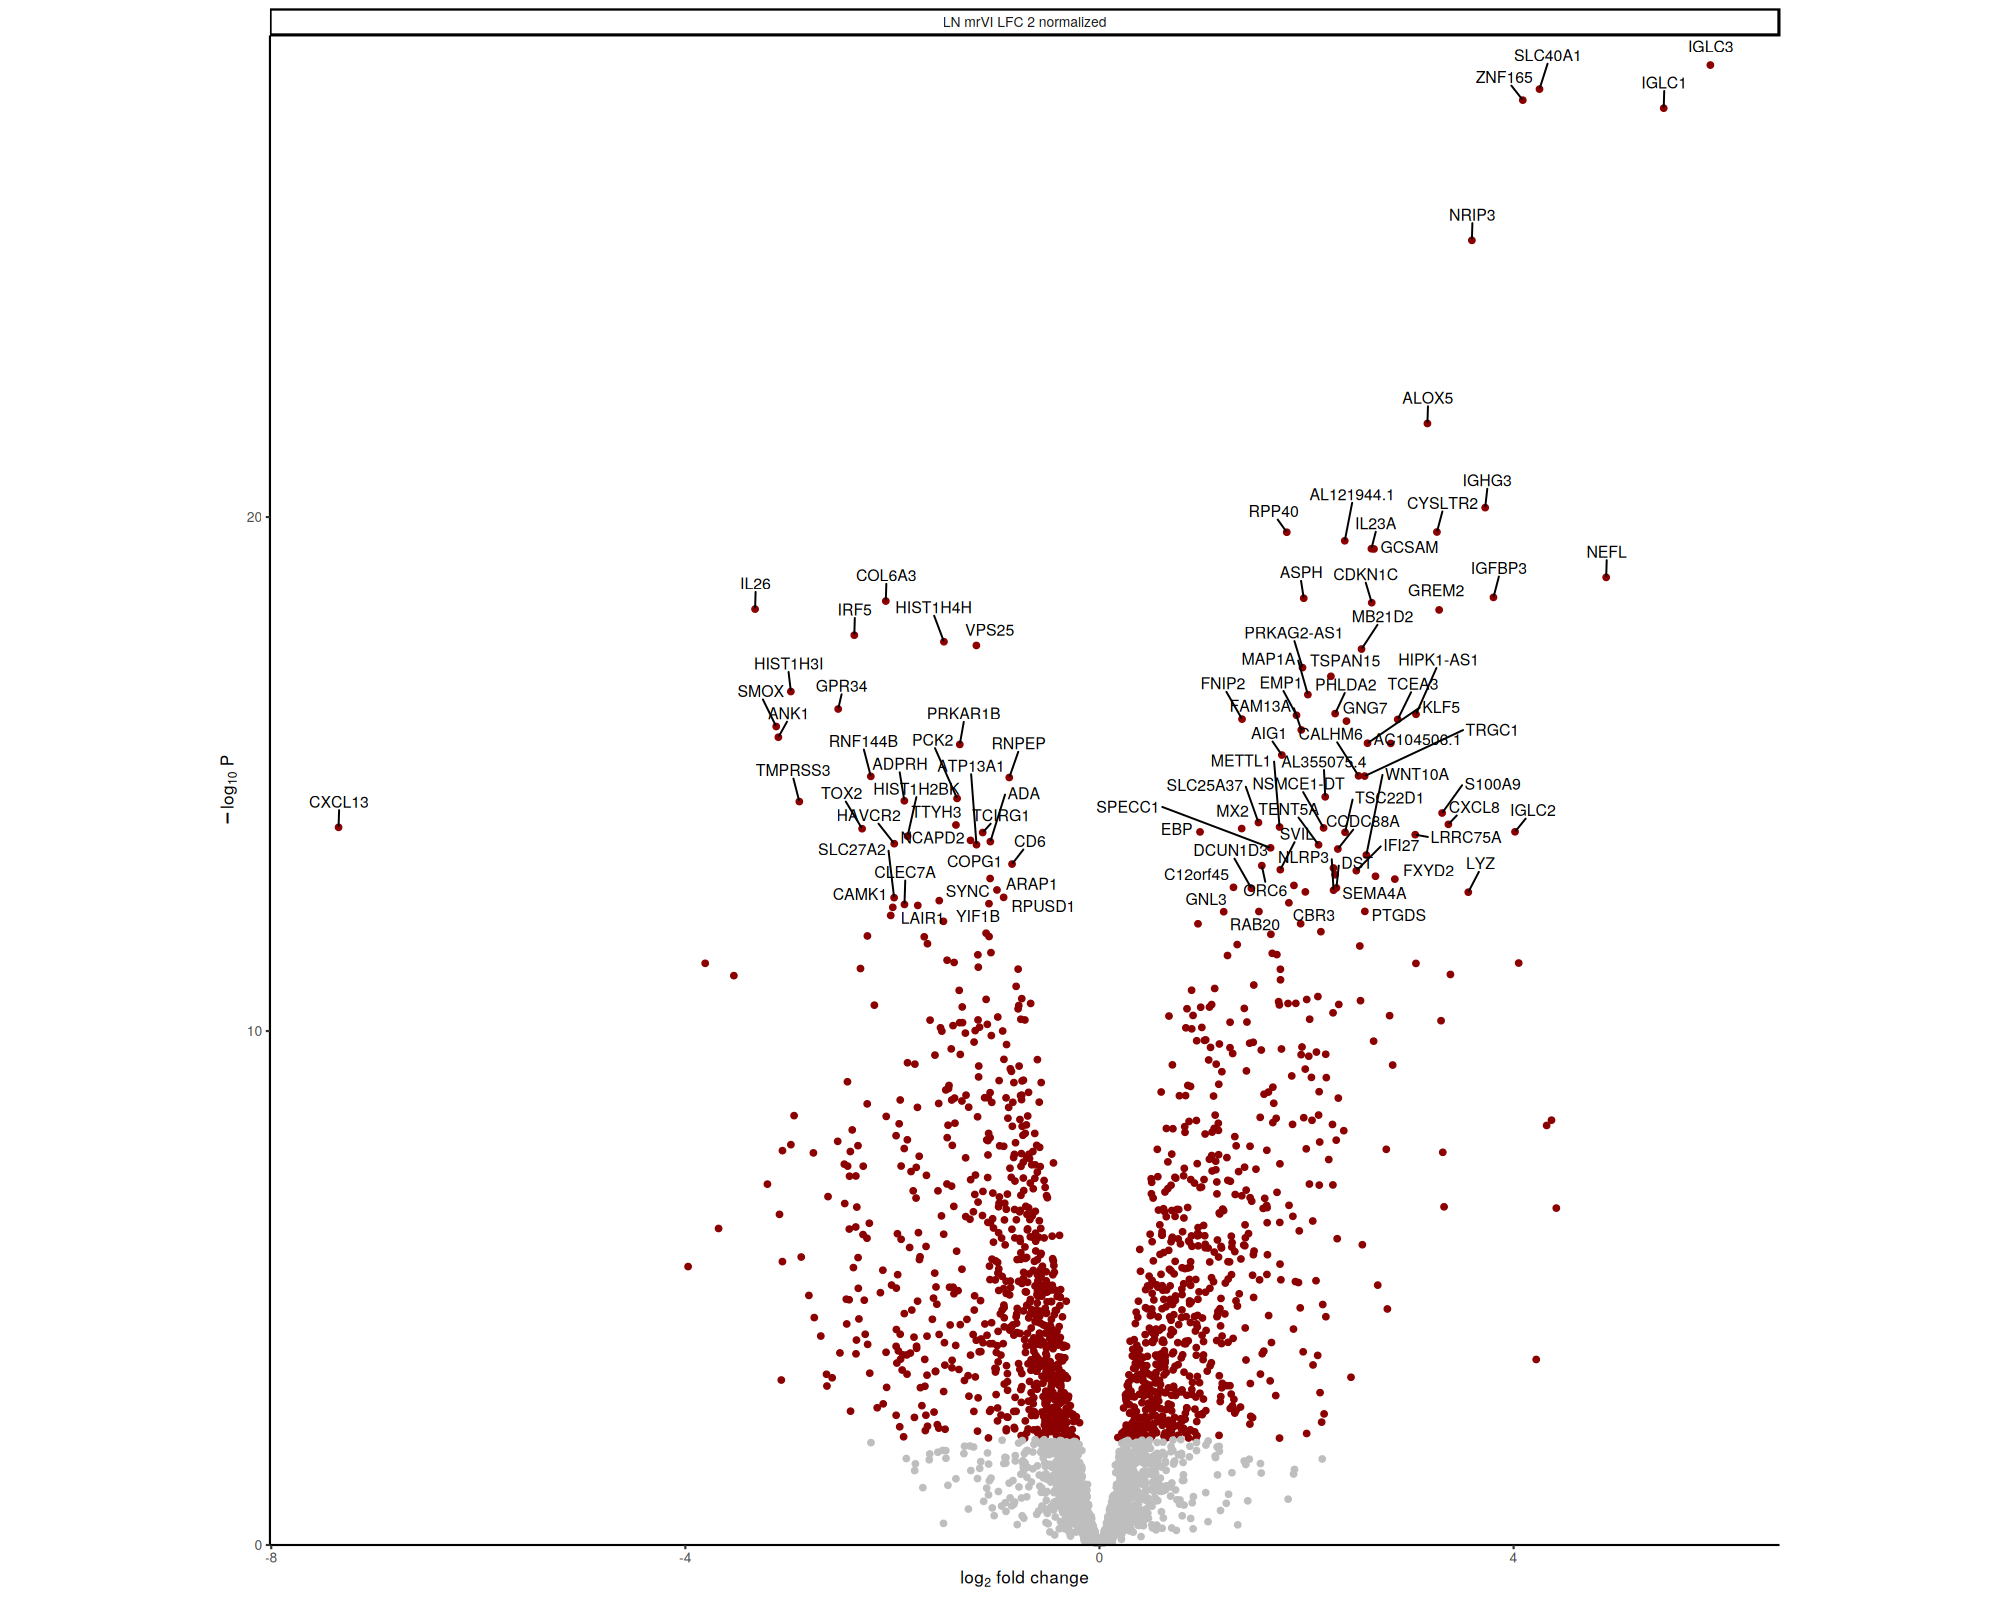

In [48]:
plotVolcano(res.dl2, coef='resp_age', nGenes=100, assay='LN mrVI LFC 2 normalized')

In [49]:
for (i in c('gut_age', 'spl_age', 'ln_age', 'blo_age', 'resp_age', 'bma_age')){
    table <- topTable(res.dl2, coef=i, number=Inf)
    write.csv(table, paste0("results_dreamlet_mrvi/ln_", i, "_random.csv"))
}

In [50]:
2

[1] 2